The *Table API* in Apache Flink is a high-level abstraction for processing structured and semi-structured data. It provides a declarative syntax (similar to SQL) for defining data transformations. Here are some key pointers to get you started:

```1. What is the Table API?```

The Table API is a unified interface for stream and batch processing.

It operates on tables (a table is a dynamic dataset in Flink).

Supports seamless integration with Flink’s SQL API and DataStream API.


```2. Key Features```

**Declarative Syntax:** Combines SQL-like semantics with programmatic API.

**Unified Processing:** Works for both bounded (batch) and unbounded (streaming) data.

**Seamless Transition:** Convert between Table and DataStream easily.

**Built-in Operators:** Support for aggregations, joins, windowing, filtering, and transformations.

In [154]:
from pyflink.table import EnvironmentSettings, TableEnvironment
from pyflink.table.expressions import col
from pyflink.table import DataTypes
import pandas as pd
from pyflink.table.schema import Schema
from pyflink.table.expressions import *
from pyflink.table.window import Tumble,Slide,Session, Over
from pyflink.table.udf import udtf


In [145]:
# env_settings = EnvironmentSettings.in_streaming_mode()
env_settings = EnvironmentSettings.in_batch_mode()
table_env = TableEnvironment.create(env_settings)

In [28]:
# Define a bounded datagen table
table_env.execute_sql(
    """
    CREATE TABLE datagen (
        id INT,
        data STRING
    ) WITH (
        'connector' = 'datagen',
        'fields.id.kind' = 'sequence',
        'fields.id.start' = '1',
        'fields.id.end' = '30',
        'number-of-rows' = '30'  -- Make it bounded by limiting the number of rows
    )
    """
)

# Query and print results
source_table = table_env.from_path('datagen')
source_table.execute().print()


+-------------+--------------------------------+
|          id |                           data |
+-------------+--------------------------------+
|           2 | 1cddf0ddf3bce9e12645131b4ca... |
|          10 | c1e796ff3f4bd966513ffc59203... |
|          18 | bd7490a99446e4f6765a9f6dbad... |
|          26 | cc95fca41f0e6c7e2803ae1b3a9... |
|           1 | f2cf542fe06b0ac0c3f61d3e9fe... |
|           9 | 82b5e57de84f5f28839480abf89... |
|          17 | 4f37274fcc1a5d6ed6fae78557c... |
|          25 | 0f3908eb319fd3afc3430c43dbd... |
|           4 | 274b34ef1a6e461e16819493e81... |
|          12 | 0f01141b8bc616c6eeb4290ace5... |
|          20 | 431baedf7deccb7d1299281dc83... |
|          28 | cf68309b331a92d806ecdd8858d... |
|           3 | 2f48121aa953b0c2c6e34d7f55e... |
|          11 | dce2ee38b8f151f03c0d4d09a16... |
|          19 | f64b173675e0c380890eb4af033... |
|          27 | bd9fd31831f83eb827d38c301d1... |
|           6 | ff483252b556d2e6a54d85efa3a... |
|          14 | 2bef

In [11]:
table = table_env.from_elements([(1, 'praveen'), (2, 'reddy'),(3,'chinna')])
table.execute().print()

+----------------------+--------------------------------+
|                   _1 |                             _2 |
+----------------------+--------------------------------+
|                    1 |                        praveen |
|                    2 |                          reddy |
|                    3 |                         chinna |
+----------------------+--------------------------------+
3 rows in set


In [14]:
table = table_env.from_elements([(1, 'praveen'), (2, 'reddy'),(3,'chinna')],DataTypes.ROW([
                                                                            DataTypes.FIELD('id',DataTypes.INT()),
                                                                            DataTypes.FIELD('name',DataTypes.STRING())
]))
table.execute().print()

+-------------+--------------------------------+
|          id |                           name |
+-------------+--------------------------------+
|           1 |                        praveen |
|           2 |                          reddy |
|           3 |                         chinna |
+-------------+--------------------------------+
3 rows in set


In [17]:
df = pd.DataFrame({'id':[1,2,3,4],'name':['praveen','reddy','chinna','reddy'],'city':['hyd','hyd','chn','chn']})
df.head()

,id,name,city
0,1,praveen,hyd
1,2,reddy,hyd
2,3,chinna,chn
3,4,reddy,chn


In [18]:
table = table_env.from_pandas(df)
table.execute().print()

+----------------------+--------------------------------+--------------------------------+
|                   id |                           name |                           city |
+----------------------+--------------------------------+--------------------------------+
|                    1 |                        praveen |                            hyd |
|                    2 |                          reddy |                            hyd |
|                    3 |                         chinna |                            chn |
|                    4 |                          reddy |                            chn |
+----------------------+--------------------------------+--------------------------------+
4 rows in set


In [68]:
table_env.execute_sql("""
    CREATE TABLE CsvTable (
        id INT,
        name STRING,
        city STRING,
        pin INT
    ) WITH (
        'connector' = 'filesystem',
        'path' = '/Users/praveenreddy/FFlink/Flink_Work/input1.csv',
        'format' = 'csv'
    )
""")

csv_table = table_env.from_path("CsvTable")

In [69]:
csv_table.execute().print()

+-------------+--------------------------------+--------------------------------+-------------+
|          id |                           name |                           city |         pin |
+-------------+--------------------------------+--------------------------------+-------------+
|           1 |                        praveen |                            hyd |       50098 |
|           2 |                          reddy |                            chn |       50092 |
|           3 |                         chinna |                            mum |       50097 |
+-------------+--------------------------------+--------------------------------+-------------+
3 rows in set


In [50]:
query = table_env.sql_query("""
    SELECT * from CsvTable where id>=2
""")
query.execute().print()

+-------------+--------------------------------+--------------------------------+-------------+
|          id |                           name |                           city |         pin |
+-------------+--------------------------------+--------------------------------+-------------+
|           2 |                          reddy |                            chn |       50092 |
|           3 |                         chinna |                            mum |       50097 |
+-------------+--------------------------------+--------------------------------+-------------+
2 rows in set


In [51]:
print(table_env.get_current_catalog()) 

default_catalog


In [52]:
print(table_env.get_current_database())

default_database


In [53]:
print(table_env.list_tables())

['CsvTable']


In [54]:
print(table_env.list_temporary_tables())

[]


In [111]:
table_env.execute_sql("""
    CREATE TABLE employee_table (
        employee_id INT,
        name STRING,
        age INT,
        department_id INT,
        salary BIGINT
    ) WITH (
        'connector' = 'filesystem',
        'path' = '/Users/praveenreddy/FFlink/Flink_Work/employee.csv',
        'format' = 'csv'
    )
""")

employee_table = table_env.from_path("employee_table")

In [112]:
table_env.execute_sql("""
    CREATE TABLE department_table (
        department_id INT,
        department_name STRING,
        location STRING
    ) WITH (
        'connector' = 'filesystem',
        'path' = '/Users/praveenreddy/FFlink/Flink_Work/department.csv',
        'format' = 'csv'
    )
""")

department_table = table_env.from_path("department_table")

In [78]:
res = employee_table.select(col("employee_id"),col("name"),col("age"))
res.execute().print()

+-------------+--------------------------------+-------------+
| employee_id |                           name |         age |
+-------------+--------------------------------+-------------+
|           1 |                           John |          29 |
|           2 |                        Michael |          32 |
|           3 |                          Sarah |          28 |
|           4 |                          Linda |          30 |
|           5 |                          James |          27 |
|           6 |                           Emma |          26 |
|           7 |                        William |          34 |
|           8 |                         Olivia |          29 |
|           9 |                          David |          31 |
|          10 |                            Amy |          28 |
|          11 |                    Christopher |          29 |
|          12 |                          Ethan |          30 |
|          13 |                         Sophia |       

In [81]:
result = employee_table.select(col("*"))
result.execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           1 |                           John |          29 |           101 |                50000 |
|           2 |                        Michael |          32 |           102 |                60000 |
|           3 |                          Sarah |          28 |           101 |                52000 |
|           4 |                          Linda |          30 |           103 |                55000 |
|           5 |                          James |          27 |           102 |                61000 |
|           6 |                           Emma |          26 |           101 |                48000 |
|           7 |                        William |          34 |           103 |    

In [84]:
result = employee_table.alias("id","name","age","dep_id","salary" )
result.execute().print()

+-------------+--------------------------------+-------------+-------------+----------------------+
|          id |                           name |         age |      dep_id |               salary |
+-------------+--------------------------------+-------------+-------------+----------------------+
|           1 |                           John |          29 |         101 |                50000 |
|           2 |                        Michael |          32 |         102 |                60000 |
|           3 |                          Sarah |          28 |         101 |                52000 |
|           4 |                          Linda |          30 |         103 |                55000 |
|           5 |                          James |          27 |         102 |                61000 |
|           6 |                           Emma |          26 |         101 |                48000 |
|           7 |                        William |          34 |         103 |                57000 |


In [85]:
result = employee_table.where(col("age")>=30)
result.execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           2 |                        Michael |          32 |           102 |                60000 |
|           4 |                          Linda |          30 |           103 |                55000 |
|           7 |                        William |          34 |           103 |                57000 |
|           9 |                          David |          31 |           101 |                50000 |
|          12 |                          Ethan |          30 |           101 |                51000 |
|          16 |                         Joshua |          33 |           103 |                58000 |
|          18 |                         Andrew |          30 |           102 |    

In [88]:

result = employee_table.add_columns(concat(col("name"), col("age").cast(DataTypes.STRING())).alias("name_age"))
result.execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+--------------------------------+
| employee_id |                           name |         age | department_id |               salary |                       name_age |
+-------------+--------------------------------+-------------+---------------+----------------------+--------------------------------+
|           1 |                           John |          29 |           101 |                50000 |                         John29 |
|           2 |                        Michael |          32 |           102 |                60000 |                      Michael32 |
|           3 |                          Sarah |          28 |           101 |                52000 |                        Sarah28 |
|           4 |                          Linda |          30 |           103 |                55000 |                        Linda30 |
|           5 |                          James |       

In [89]:

result = employee_table.add_or_replace_columns(
        concat(col("name"), " Reddy").alias("name")
    )
result.execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           1 |                     John Reddy |          29 |           101 |                50000 |
|           2 |                  Michael Reddy |          32 |           102 |                60000 |
|           3 |                    Sarah Reddy |          28 |           101 |                52000 |
|           4 |                    Linda Reddy |          30 |           103 |                55000 |
|           5 |                    James Reddy |          27 |           102 |                61000 |
|           6 |                     Emma Reddy |          26 |           101 |                48000 |
|           7 |                  William Reddy |          34 |           103 |    

In [90]:

result = employee_table.drop_columns(col("name"),col("department_id"))
result.execute().print()

+-------------+-------------+----------------------+
| employee_id |         age |               salary |
+-------------+-------------+----------------------+
|           1 |          29 |                50000 |
|           2 |          32 |                60000 |
|           3 |          28 |                52000 |
|           4 |          30 |                55000 |
|           5 |          27 |                61000 |
|           6 |          26 |                48000 |
|           7 |          34 |                57000 |
|           8 |          29 |                59000 |
|           9 |          31 |                50000 |
|          10 |          28 |                52000 |
|          11 |          29 |                54000 |
|          12 |          30 |                51000 |
|          13 |          25 |                53000 |
|          14 |          28 |                50000 |
|          15 |          27 |                62000 |
|          16 |          33 |                5

In [91]:

result = employee_table.rename_columns(col('employee_id').alias('id'))
result.execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
|          id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           1 |                           John |          29 |           101 |                50000 |
|           2 |                        Michael |          32 |           102 |                60000 |
|           3 |                          Sarah |          28 |           101 |                52000 |
|           4 |                          Linda |          30 |           103 |                55000 |
|           5 |                          James |          27 |           102 |                61000 |
|           6 |                           Emma |          26 |           101 |                48000 |
|           7 |                        William |          34 |           103 |    

In [94]:
result = employee_table.group_by(col('age')).select(col('age'),col('salary').sum.alias('salary_by_age'))
result.execute().print()

+-------------+----------------------+
|         age |        salary_by_age |
+-------------+----------------------+
|          25 |               100000 |
|          30 |               219000 |
|          28 |               302000 |
|          31 |                50000 |
|          29 |               269000 |
|          32 |                60000 |
|          26 |               207000 |
|          27 |               285000 |
|          34 |                57000 |
|          33 |                58000 |
+-------------+----------------------+
10 rows in set


In [96]:
result = employee_table.group_by(col('age')).select(col('age'),col('salary').avg.alias('avg_by_age'))
result.execute().print()

+-------------+----------------------+
|         age |           avg_by_age |
+-------------+----------------------+
|          25 |                50000 |
|          30 |                54750 |
|          28 |                50333 |
|          31 |                50000 |
|          29 |                53800 |
|          32 |                60000 |
|          26 |                51750 |
|          27 |                57000 |
|          34 |                57000 |
|          33 |                58000 |
+-------------+----------------------+
10 rows in set


In [146]:
table_env.execute_sql("""
    CREATE TABLE orders_table (
        order_id STRING,
        product STRING,
        price BIGINT,
        quantity INT,
        ordered_time TIMESTAMP
    ) WITH (
        'connector' = 'filesystem',
        'path' = '/Users/praveenreddy/FFlink/Flink_Work/orders.csv',
        'format' = 'csv'
    )
""")

orders_table = table_env.from_path("orders_table")

In [101]:
orders_table.execute().print()

+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                           ORD1 |                      Product_1 |                  100 |           1 | 2024-12-14 09:33:05.000000 |
|                           ORD2 |                      Product_2 |                  110 |           2 | 2024-12-14 09:38:05.000000 |
|                           ORD3 |                      Product_3 |                  120 |           3 | 2024-12-14 09:43:05.000000 |
|                           ORD4 |                      Product_4 |                  130 |           4 | 2024-12-14 09:48:05.000000 |
|                           ORD5 |                      Produc

#### Windows are a core concept for grouping unbounded data streams into bounded logical chunks of data. Since streams are infinite, Flink uses windows to group data for processing and analysis. 


Tumbling Window :: 
A Tumbling Window groups data into non-overlapping, fixed-sized intervals. Each incoming event fits exactly into one window.

Session Window :: 
A Session Window groups data based on gaps in event activity. If there's a defined gap of inactivity, a new window starts.

Sliding Window :: 
A Sliding Window groups data into overlapping windows, where each window has a defined size and slides at a specified interval.

Slide Window 

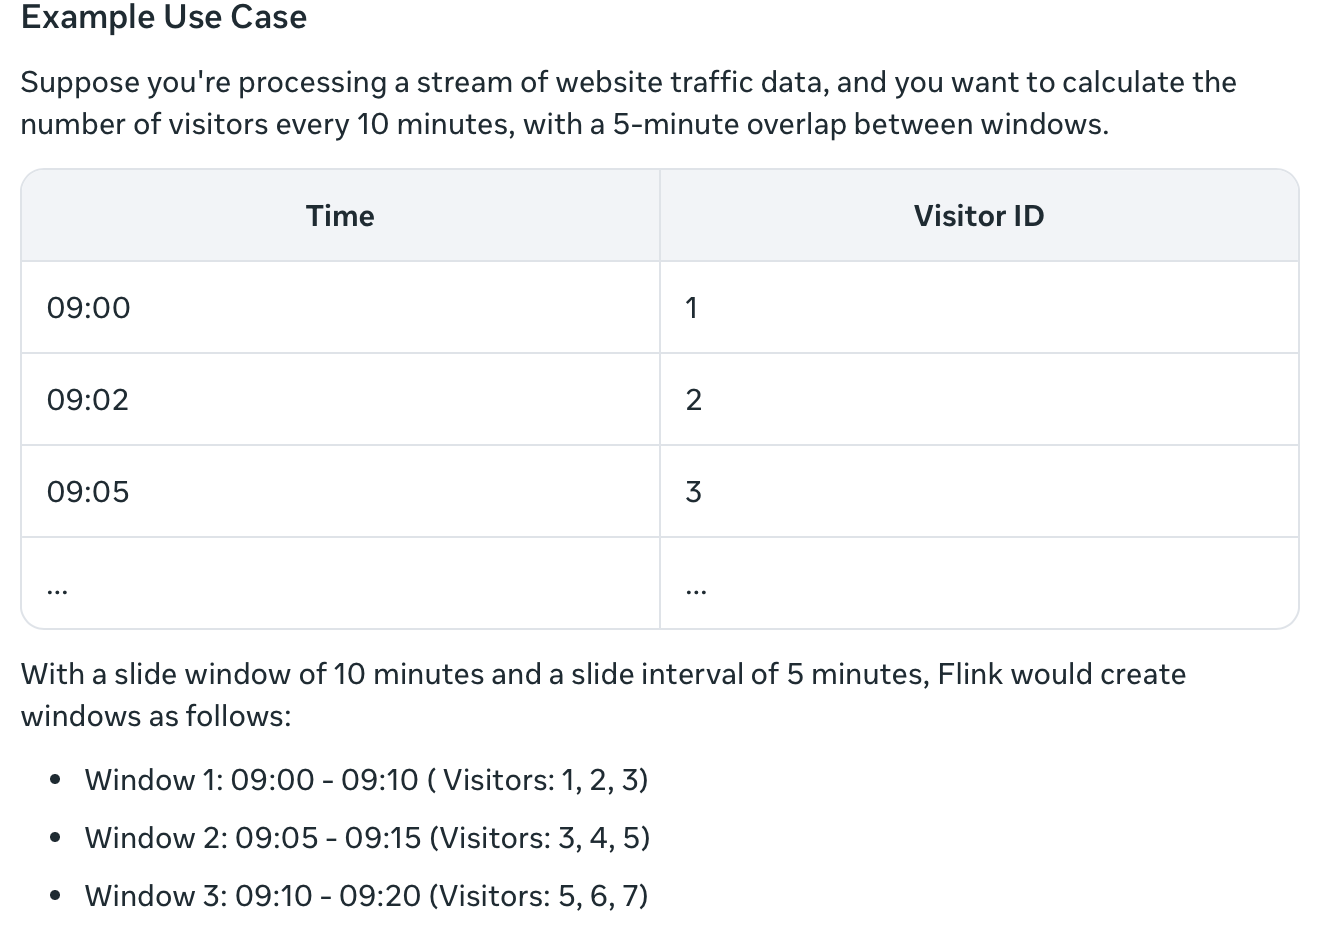

In [147]:
result = orders_table.window(Tumble.over(lit(15).minutes).on(col('ordered_time')).alias("ordered_time")) \
            .group_by(col('product'),col('ordered_time')).select(col('product'),col('price').sum.alias('sum_by_product'))
result.execute().print()

+--------------------------------+----------------------+
|                        product |       sum_by_product |
+--------------------------------+----------------------+
|                      Product_1 |                  210 |
|                      Product_1 |                  150 |
|                      Product_3 |                  510 |
|                     Product_15 |                  290 |
|                     Product_14 |                  780 |
|                     Product_14 |                  280 |
|                      Product_2 |                  120 |
|                      Product_2 |                  270 |
|                     Product_13 |                  690 |
|                     Product_11 |                  600 |
+--------------------------------+----------------------+
10 rows in set


In [149]:
result = orders_table.window(Slide.over(lit(15).minutes).every(lit(5).minutes).on(col('ordered_time')).alias("ordered_time")) \
            .group_by(col('product'),col('ordered_time')).select(col('product'),col('price').sum.alias('sum_by_product'))
result.execute().print()

+--------------------------------+----------------------+
|                        product |       sum_by_product |
+--------------------------------+----------------------+
|                      Product_1 |                  100 |
|                      Product_1 |                  210 |
|                      Product_1 |                  210 |
|                      Product_1 |                  110 |
|                      Product_1 |                  150 |
|                      Product_1 |                  150 |
|                      Product_1 |                  150 |
|                     Product_11 |                  190 |
|                     Product_11 |                  390 |
|                     Product_11 |                  600 |
|                     Product_11 |                  410 |
|                     Product_11 |                  210 |
|                     Product_13 |                  220 |
|                     Product_13 |                  450 |
|             

In [152]:
result = orders_table.window(Session.with_gap(lit(10).minutes).on(col('ordered_time')).alias("ordered_time")) \
            .group_by(col('product'),col('ordered_time')).select(col('product'),col('price').sum.alias('sum_by_product'))
result.execute().print()

TableException: org.apache.flink.table.api.TableException: Sql optimization: Cannot generate a valid execution plan for the given query: 

FlinkLogicalSink(table=[*anonymous_collect$64*], fields=[product, sum_by_product])
+- FlinkLogicalCalc(select=[product, EXPR$0 AS sum_by_product])
   +- FlinkLogicalWindowAggregate(group=[{1}], EXPR$0=[SUM($2)], window=[SessionGroupWindow('ordered_time, ordered_time, 600000)], properties=[])
      +- FlinkLogicalTableSourceScan(table=[[default_catalog, default_database, orders_table]], fields=[order_id, product, price, quantity, ordered_time])

Window SessionGroupWindow('ordered_time, ordered_time, 600000) is not supported right now.
Please check the documentation for the set of currently supported SQL features.
	at org.apache.flink.table.planner.plan.optimize.program.FlinkVolcanoProgram.optimize(FlinkVolcanoProgram.scala:86)
	at org.apache.flink.table.planner.plan.optimize.program.FlinkChainedProgram.$anonfun$optimize$1(FlinkChainedProgram.scala:59)
	at scala.collection.TraversableOnce.$anonfun$foldLeft$1(TraversableOnce.scala:156)
	at scala.collection.TraversableOnce.$anonfun$foldLeft$1$adapted(TraversableOnce.scala:156)
	at scala.collection.Iterator.foreach(Iterator.scala:937)
	at scala.collection.Iterator.foreach$(Iterator.scala:937)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1425)
	at scala.collection.IterableLike.foreach(IterableLike.scala:70)
	at scala.collection.IterableLike.foreach$(IterableLike.scala:69)
	at scala.collection.AbstractIterable.foreach(Iterable.scala:54)
	at scala.collection.TraversableOnce.foldLeft(TraversableOnce.scala:156)
	at scala.collection.TraversableOnce.foldLeft$(TraversableOnce.scala:154)
	at scala.collection.AbstractTraversable.foldLeft(Traversable.scala:104)
	at org.apache.flink.table.planner.plan.optimize.program.FlinkChainedProgram.optimize(FlinkChainedProgram.scala:55)
	at org.apache.flink.table.planner.plan.optimize.BatchCommonSubGraphBasedOptimizer.optimizeTree(BatchCommonSubGraphBasedOptimizer.scala:93)
	at org.apache.flink.table.planner.plan.optimize.BatchCommonSubGraphBasedOptimizer.optimizeBlock(BatchCommonSubGraphBasedOptimizer.scala:58)
	at org.apache.flink.table.planner.plan.optimize.BatchCommonSubGraphBasedOptimizer.$anonfun$doOptimize$1(BatchCommonSubGraphBasedOptimizer.scala:45)
	at org.apache.flink.table.planner.plan.optimize.BatchCommonSubGraphBasedOptimizer.$anonfun$doOptimize$1$adapted(BatchCommonSubGraphBasedOptimizer.scala:45)
	at scala.collection.immutable.List.foreach(List.scala:388)
	at org.apache.flink.table.planner.plan.optimize.BatchCommonSubGraphBasedOptimizer.doOptimize(BatchCommonSubGraphBasedOptimizer.scala:45)
	at org.apache.flink.table.planner.plan.optimize.CommonSubGraphBasedOptimizer.optimize(CommonSubGraphBasedOptimizer.scala:87)
	at org.apache.flink.table.planner.delegation.PlannerBase.optimize(PlannerBase.scala:320)
	at org.apache.flink.table.planner.delegation.PlannerBase.translate(PlannerBase.scala:178)
	at org.apache.flink.table.api.internal.TableEnvironmentImpl.translate(TableEnvironmentImpl.java:1308)
	at org.apache.flink.table.api.internal.TableEnvironmentImpl.executeInternal(TableEnvironmentImpl.java:1133)
	at org.apache.flink.table.api.internal.TableImpl.execute(TableImpl.java:477)
	at jdk.internal.reflect.GeneratedMethodAccessor79.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at org.apache.flink.api.python.shaded.py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at org.apache.flink.api.python.shaded.py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at org.apache.flink.api.python.shaded.py4j.Gateway.invoke(Gateway.java:282)
	at org.apache.flink.api.python.shaded.py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at org.apache.flink.api.python.shaded.py4j.commands.CallCommand.execute(CallCommand.java:79)
	at org.apache.flink.api.python.shaded.py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.flink.table.api.TableException: Window SessionGroupWindow('ordered_time, ordered_time, 600000) is not supported right now.
	at org.apache.flink.table.planner.plan.rules.physical.batch.BatchPhysicalWindowAggregateRule.onMatch(BatchPhysicalWindowAggregateRule.scala:142)
	at org.apache.calcite.plan.volcano.VolcanoRuleCall.onMatch(VolcanoRuleCall.java:223)
	at org.apache.calcite.plan.volcano.IterativeRuleDriver.drive(IterativeRuleDriver.java:59)
	at org.apache.calcite.plan.volcano.VolcanoPlanner.findBestExp(VolcanoPlanner.java:523)
	at org.apache.calcite.tools.Programs$RuleSetProgram.run(Programs.java:318)
	at org.apache.flink.table.planner.plan.optimize.program.FlinkVolcanoProgram.optimize(FlinkVolcanoProgram.scala:62)
	... 35 more


In [106]:
orders_table.distinct().execute().print()

+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                          ORD11 |                     Product_11 |                  200 |           1 | 2024-12-14 10:23:05.000000 |
|                          ORD12 |                     Product_11 |                  210 |           2 | 2024-12-14 10:28:05.000000 |
|                          ORD13 |                     Product_13 |                  220 |           3 | 2024-12-14 10:33:05.000000 |
|                          ORD15 |                     Product_13 |                  240 |           5 | 2024-12-14 10:43:05.000000 |
|                          ORD20 |                     Product

In [ ]:
emp_table = employee_table.rename_columns(col('department_id').alias('dept_id'))

In [ ]:

result = emp_table.join(department_table).where(col('dept_id') == col('department_id'))
result.execute().print()

+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
| employee_id |                           name |         age |     dept_id |               salary | department_id |                department_name |                       location |
+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
|           1 |                           John |          29 |         101 |                50000 |           101 |                    Engineering |                      Hyderabad |
|           2 |                        Michael |          32 |         102 |                60000 |           102 |                          Sales |                        Chennai |
|           3 |                          Sarah |          28 |         101 |              

In [114]:
result = emp_table.left_outer_join(department_table,col('dept_id') == col('department_id'))
result.execute().print()

+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
| employee_id |                           name |         age |     dept_id |               salary | department_id |                department_name |                       location |
+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
|           1 |                           John |          29 |         101 |                50000 |           101 |                    Engineering |                      Hyderabad |
|           2 |                        Michael |          32 |         102 |                60000 |           102 |                          Sales |                        Chennai |
|           3 |                          Sarah |          28 |         101 |              

In [115]:
result = emp_table.right_outer_join(department_table,col('dept_id') == col('department_id'))
result.execute().print()

+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
| employee_id |                           name |         age |     dept_id |               salary | department_id |                department_name |                       location |
+-------------+--------------------------------+-------------+-------------+----------------------+---------------+--------------------------------+--------------------------------+
|           1 |                           John |          29 |         101 |                50000 |           101 |                    Engineering |                      Hyderabad |
|           3 |                          Sarah |          28 |         101 |                52000 |           101 |                    Engineering |                      Hyderabad |
|           6 |                           Emma |          26 |         101 |              

#### join_lateral is a powerful operator in Apache Flink that allows you to combine a table with the output of a Table Function (like a UDTF) dynamically.

In [131]:
orders_table.execute().print()

+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                           ORD1 |                      Product_1 |                  100 |           1 | 2024-12-14 09:33:05.000000 |
|                           ORD2 |                      Product_1 |                  110 |           2 | 2024-12-14 09:38:05.000000 |
|                           ORD3 |                      Product_2 |                  120 |           3 | 2024-12-14 09:43:05.000000 |
|                           ORD4 |                      Product_2 |                  130 |           4 | 2024-12-14 09:48:05.000000 |
|                           ORD5 |                      Produc

In [133]:
@udtf(result_types=[DataTypes.STRING(), DataTypes.FLOAT()])
def calculate_discount(product_name):
    try:
        import random
        discount_percentage = round(random.uniform(5, 30), 2)
        return [product_name, discount_percentage]
    except Exception as e:
        print(f"Failed to calculate discount for {product_name}: {e}")
        # Always return a list with 2 items to match the expected result_types
        return [product_name if product_name else "Unknown", 0.0]


joined_orders = orders_table.left_outer_join_lateral(calculate_discount(col('product'))\
                        .alias("name", "discount"))

# Select relevant columns
result = joined_orders.select(col('order_id'), col('name'), col('price'), col('discount'))

result.execute().print()

Traceback (most recent call last):
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 295, in _execute
    response = task()
               ^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 370, in <lambda>
    lambda: self.create_worker().do_instruction(request), request)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 629, in do_instruction
    return getattr(self, request_type)(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 667, in process_bundle
    bundle_processor.process_bundle(instruction_id))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/p

Py4JJavaError: An error occurred while calling o2427.print.
: java.lang.RuntimeException: Failed to fetch next result
	at org.apache.flink.streaming.api.operators.collect.CollectResultIterator.nextResultFromFetcher(CollectResultIterator.java:129)
	at org.apache.flink.streaming.api.operators.collect.CollectResultIterator.hasNext(CollectResultIterator.java:100)
	at org.apache.flink.table.planner.connectors.CollectDynamicSink$CloseableRowIteratorWrapper.hasNext(CollectDynamicSink.java:247)
	at org.apache.flink.table.utils.print.TableauStyle.print(TableauStyle.java:120)
	at org.apache.flink.table.api.internal.TableResultImpl.print(TableResultImpl.java:163)
	at jdk.internal.reflect.GeneratedMethodAccessor114.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at org.apache.flink.api.python.shaded.py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at org.apache.flink.api.python.shaded.py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at org.apache.flink.api.python.shaded.py4j.Gateway.invoke(Gateway.java:282)
	at org.apache.flink.api.python.shaded.py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at org.apache.flink.api.python.shaded.py4j.commands.CallCommand.execute(CallCommand.java:79)
	at org.apache.flink.api.python.shaded.py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.io.IOException: Failed to fetch job execution result
	at org.apache.flink.streaming.api.operators.collect.CollectResultFetcher.getAccumulatorResults(CollectResultFetcher.java:187)
	at org.apache.flink.streaming.api.operators.collect.CollectResultFetcher.next(CollectResultFetcher.java:123)
	at org.apache.flink.streaming.api.operators.collect.CollectResultIterator.nextResultFromFetcher(CollectResultIterator.java:126)
	... 14 more
Caused by: java.util.concurrent.ExecutionException: org.apache.flink.runtime.client.JobExecutionException: Job execution failed.
	at java.base/java.util.concurrent.CompletableFuture.reportGet(CompletableFuture.java:396)
	at java.base/java.util.concurrent.CompletableFuture.get(CompletableFuture.java:2096)
	at org.apache.flink.streaming.api.operators.collect.CollectResultFetcher.getAccumulatorResults(CollectResultFetcher.java:185)
	... 16 more
Caused by: org.apache.flink.runtime.client.JobExecutionException: Job execution failed.
	at org.apache.flink.runtime.jobmaster.JobResult.toJobExecutionResult(JobResult.java:144)
	at org.apache.flink.runtime.minicluster.MiniClusterJobClient.lambda$getJobExecutionResult$3(MiniClusterJobClient.java:141)
	at java.base/java.util.concurrent.CompletableFuture$UniApply.tryFire(CompletableFuture.java:646)
	at java.base/java.util.concurrent.CompletableFuture.postComplete(CompletableFuture.java:510)
	at java.base/java.util.concurrent.CompletableFuture.complete(CompletableFuture.java:2147)
	at org.apache.flink.runtime.rpc.pekko.PekkoInvocationHandler.lambda$invokeRpc$1(PekkoInvocationHandler.java:268)
	at java.base/java.util.concurrent.CompletableFuture.uniWhenComplete(CompletableFuture.java:863)
	at java.base/java.util.concurrent.CompletableFuture$UniWhenComplete.tryFire(CompletableFuture.java:841)
	at java.base/java.util.concurrent.CompletableFuture.postComplete(CompletableFuture.java:510)
	at java.base/java.util.concurrent.CompletableFuture.complete(CompletableFuture.java:2147)
	at org.apache.flink.util.concurrent.FutureUtils.doForward(FutureUtils.java:1287)
	at org.apache.flink.runtime.concurrent.ClassLoadingUtils.lambda$null$1(ClassLoadingUtils.java:93)
	at org.apache.flink.runtime.concurrent.ClassLoadingUtils.runWithContextClassLoader(ClassLoadingUtils.java:68)
	at org.apache.flink.runtime.concurrent.ClassLoadingUtils.lambda$guardCompletionWithContextClassLoader$2(ClassLoadingUtils.java:92)
	at java.base/java.util.concurrent.CompletableFuture.uniWhenComplete(CompletableFuture.java:863)
	at java.base/java.util.concurrent.CompletableFuture$UniWhenComplete.tryFire(CompletableFuture.java:841)
	at java.base/java.util.concurrent.CompletableFuture.postComplete(CompletableFuture.java:510)
	at java.base/java.util.concurrent.CompletableFuture.complete(CompletableFuture.java:2147)
	at org.apache.flink.runtime.concurrent.pekko.ScalaFutureUtils$1.onComplete(ScalaFutureUtils.java:47)
	at org.apache.pekko.dispatch.OnComplete.internal(Future.scala:310)
	at org.apache.pekko.dispatch.OnComplete.internal(Future.scala:307)
	at org.apache.pekko.dispatch.japi$CallbackBridge.apply(Future.scala:234)
	at org.apache.pekko.dispatch.japi$CallbackBridge.apply(Future.scala:231)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.flink.runtime.concurrent.pekko.ScalaFutureUtils$DirectExecutionContext.execute(ScalaFutureUtils.java:65)
	at scala.concurrent.impl.CallbackRunnable.executeWithValue(Promise.scala:72)
	at scala.concurrent.impl.Promise$DefaultPromise.$anonfun$tryComplete$1(Promise.scala:288)
	at scala.concurrent.impl.Promise$DefaultPromise.$anonfun$tryComplete$1$adapted(Promise.scala:288)
	at scala.concurrent.impl.Promise$DefaultPromise.tryComplete(Promise.scala:288)
	at org.apache.pekko.pattern.PromiseActorRef.$bang(AskSupport.scala:629)
	at org.apache.pekko.pattern.PipeToSupport$PipeableFuture$$anonfun$pipeTo$1.applyOrElse(PipeToSupport.scala:34)
	at org.apache.pekko.pattern.PipeToSupport$PipeableFuture$$anonfun$pipeTo$1.applyOrElse(PipeToSupport.scala:33)
	at scala.concurrent.Future.$anonfun$andThen$1(Future.scala:536)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.pekko.dispatch.BatchingExecutor$AbstractBatch.processBatch(BatchingExecutor.scala:73)
	at org.apache.pekko.dispatch.BatchingExecutor$BlockableBatch.$anonfun$run$1(BatchingExecutor.scala:110)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at scala.concurrent.BlockContext$.withBlockContext(BlockContext.scala:85)
	at org.apache.pekko.dispatch.BatchingExecutor$BlockableBatch.run(BatchingExecutor.scala:110)
	at org.apache.pekko.dispatch.TaskInvocation.run(AbstractDispatcher.scala:59)
	at org.apache.pekko.dispatch.ForkJoinExecutorConfigurator$PekkoForkJoinTask.exec(ForkJoinExecutorConfigurator.scala:57)
	at java.base/java.util.concurrent.ForkJoinTask.doExec(ForkJoinTask.java:373)
	at java.base/java.util.concurrent.ForkJoinPool$WorkQueue.topLevelExec(ForkJoinPool.java:1182)
	at java.base/java.util.concurrent.ForkJoinPool.scan(ForkJoinPool.java:1655)
	at java.base/java.util.concurrent.ForkJoinPool.runWorker(ForkJoinPool.java:1622)
	at java.base/java.util.concurrent.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:165)
Caused by: org.apache.flink.runtime.JobException: Recovery is suppressed by NoRestartBackoffTimeStrategy
	at org.apache.flink.runtime.executiongraph.failover.ExecutionFailureHandler.handleFailure(ExecutionFailureHandler.java:219)
	at org.apache.flink.runtime.executiongraph.failover.ExecutionFailureHandler.handleFailureAndReport(ExecutionFailureHandler.java:166)
	at org.apache.flink.runtime.executiongraph.failover.ExecutionFailureHandler.getFailureHandlingResult(ExecutionFailureHandler.java:121)
	at org.apache.flink.runtime.scheduler.DefaultScheduler.recordTaskFailure(DefaultScheduler.java:281)
	at org.apache.flink.runtime.scheduler.DefaultScheduler.handleTaskFailure(DefaultScheduler.java:272)
	at org.apache.flink.runtime.scheduler.adaptivebatch.AdaptiveBatchScheduler.handleTaskFailure(AdaptiveBatchScheduler.java:413)
	at org.apache.flink.runtime.scheduler.DefaultScheduler.onTaskFailed(DefaultScheduler.java:265)
	at org.apache.flink.runtime.scheduler.adaptivebatch.AdaptiveBatchScheduler.onTaskFailed(AdaptiveBatchScheduler.java:405)
	at org.apache.flink.runtime.scheduler.SchedulerBase.onTaskExecutionStateUpdate(SchedulerBase.java:787)
	at org.apache.flink.runtime.scheduler.SchedulerBase.updateTaskExecutionState(SchedulerBase.java:764)
	at org.apache.flink.runtime.scheduler.SchedulerNG.updateTaskExecutionState(SchedulerNG.java:83)
	at org.apache.flink.runtime.jobmaster.JobMaster.updateTaskExecutionState(JobMaster.java:515)
	at jdk.internal.reflect.GeneratedMethodAccessor13.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:568)
	at org.apache.flink.runtime.rpc.pekko.PekkoRpcActor.lambda$handleRpcInvocation$1(PekkoRpcActor.java:318)
	at org.apache.flink.runtime.concurrent.ClassLoadingUtils.runWithContextClassLoader(ClassLoadingUtils.java:83)
	at org.apache.flink.runtime.rpc.pekko.PekkoRpcActor.handleRpcInvocation(PekkoRpcActor.java:316)
	at org.apache.flink.runtime.rpc.pekko.PekkoRpcActor.handleRpcMessage(PekkoRpcActor.java:229)
	at org.apache.flink.runtime.rpc.pekko.FencedPekkoRpcActor.handleRpcMessage(FencedPekkoRpcActor.java:88)
	at org.apache.flink.runtime.rpc.pekko.PekkoRpcActor.handleMessage(PekkoRpcActor.java:174)
	at org.apache.pekko.japi.pf.UnitCaseStatement.apply(CaseStatements.scala:33)
	at org.apache.pekko.japi.pf.UnitCaseStatement.apply(CaseStatements.scala:29)
	at scala.PartialFunction.applyOrElse(PartialFunction.scala:127)
	at scala.PartialFunction.applyOrElse$(PartialFunction.scala:126)
	at org.apache.pekko.japi.pf.UnitCaseStatement.applyOrElse(CaseStatements.scala:29)
	at scala.PartialFunction$OrElse.applyOrElse(PartialFunction.scala:175)
	at scala.PartialFunction$OrElse.applyOrElse(PartialFunction.scala:176)
	at scala.PartialFunction$OrElse.applyOrElse(PartialFunction.scala:176)
	at org.apache.pekko.actor.Actor.aroundReceive(Actor.scala:547)
	at org.apache.pekko.actor.Actor.aroundReceive$(Actor.scala:545)
	at org.apache.pekko.actor.AbstractActor.aroundReceive(AbstractActor.scala:229)
	at org.apache.pekko.actor.ActorCell.receiveMessage(ActorCell.scala:590)
	at org.apache.pekko.actor.ActorCell.invoke(ActorCell.scala:557)
	at org.apache.pekko.dispatch.Mailbox.processMailbox(Mailbox.scala:280)
	at org.apache.pekko.dispatch.Mailbox.run(Mailbox.scala:241)
	at org.apache.pekko.dispatch.Mailbox.exec(Mailbox.scala:253)
	... 5 more
Caused by: java.lang.RuntimeException: Error while waiting for BeamPythonFunctionRunner flush
	at org.apache.flink.streaming.api.operators.python.process.AbstractExternalPythonFunctionOperator.invokeFinishBundle(AbstractExternalPythonFunctionOperator.java:107)
	at org.apache.flink.streaming.api.operators.python.AbstractPythonFunctionOperator.processWatermark(AbstractPythonFunctionOperator.java:189)
	at org.apache.flink.streaming.runtime.tasks.ChainingOutput.emitWatermark(ChainingOutput.java:122)
	at org.apache.flink.streaming.runtime.tasks.SourceOperatorStreamTask$AsyncDataOutputToOutput.emitWatermark(SourceOperatorStreamTask.java:330)
	at org.apache.flink.streaming.runtime.tasks.SourceOperatorStreamTask.advanceToEndOfEventTime(SourceOperatorStreamTask.java:213)
	at org.apache.flink.streaming.runtime.tasks.StreamTask.endData(StreamTask.java:692)
	at org.apache.flink.streaming.runtime.tasks.StreamTask.processInput(StreamTask.java:653)
	at org.apache.flink.streaming.runtime.tasks.mailbox.MailboxProcessor.runMailboxLoop(MailboxProcessor.java:231)
	at org.apache.flink.streaming.runtime.tasks.StreamTask.runMailboxLoop(StreamTask.java:973)
	at org.apache.flink.streaming.runtime.tasks.StreamTask.invoke(StreamTask.java:917)
	at org.apache.flink.runtime.taskmanager.Task.runWithSystemExitMonitoring(Task.java:970)
	at org.apache.flink.runtime.taskmanager.Task.restoreAndInvoke(Task.java:949)
	at org.apache.flink.runtime.taskmanager.Task.doRun(Task.java:763)
	at org.apache.flink.runtime.taskmanager.Task.run(Task.java:575)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: java.lang.RuntimeException: Failed to close remote bundle
	at org.apache.flink.streaming.api.runners.python.beam.BeamPythonFunctionRunner.finishBundle(BeamPythonFunctionRunner.java:423)
	at org.apache.flink.streaming.api.runners.python.beam.BeamPythonFunctionRunner.flush(BeamPythonFunctionRunner.java:407)
	at org.apache.flink.streaming.api.operators.python.process.AbstractExternalPythonFunctionOperator.lambda$invokeFinishBundle$0(AbstractExternalPythonFunctionOperator.java:86)
	at java.base/java.util.concurrent.Executors$RunnableAdapter.call(Executors.java:539)
	at java.base/java.util.concurrent.FutureTask.run(FutureTask.java:264)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	... 1 more
Caused by: java.util.concurrent.ExecutionException: java.lang.RuntimeException: Error received from SDK harness for instruction 1: Traceback (most recent call last):
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 295, in _execute
    response = task()
               ^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 370, in <lambda>
    lambda: self.create_worker().do_instruction(request), request)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 629, in do_instruction
    return getattr(self, request_type)(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 667, in process_bundle
    bundle_processor.process_bundle(instruction_id))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/bundle_processor.py", line 1061, in process_bundle
    input_op_by_transform_id[element.transform_id].process_encoded(
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/bundle_processor.py", line 231, in process_encoded
    self.output(decoded_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/operations.py", line 528, in output
    _cast_to_receiver(self.receivers[output_index]).receive(windowed_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/operations.py", line 240, in receive
    self.consumer.process(windowed_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_operations_slow.py", line 151, in process
    self._main_output_processor.process_outputs(
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_operations_slow.py", line 52, in process_outputs
    self._value_coder_impl.encode_to_stream(results, output_stream, True)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_coder_impl_slow.py", line 75, in encode_to_stream
    self._value_coder.encode_to_stream(value, self._data_output_stream)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/coder_impl_slow.py", line 100, in encode_to_stream
    self._field_coder.encode_to_stream(item, self._data_out_stream)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/coder_impl_slow.py", line 219, in encode_to_stream
    item = value[i]
           ~~~~~^^^
IndexError: list index out of range

	at java.base/java.util.concurrent.CompletableFuture.reportGet(CompletableFuture.java:396)
	at java.base/java.util.concurrent.CompletableFuture.get(CompletableFuture.java:2073)
	at org.apache.beam.sdk.util.MoreFutures.get(MoreFutures.java:61)
	at org.apache.beam.runners.fnexecution.control.SdkHarnessClient$BundleProcessor$ActiveBundle.close(SdkHarnessClient.java:504)
	at org.apache.beam.runners.fnexecution.control.DefaultJobBundleFactory$SimpleStageBundleFactory$1.close(DefaultJobBundleFactory.java:607)
	at org.apache.flink.streaming.api.runners.python.beam.BeamPythonFunctionRunner.finishBundle(BeamPythonFunctionRunner.java:421)
	... 7 more
Caused by: java.lang.RuntimeException: Error received from SDK harness for instruction 1: Traceback (most recent call last):
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 295, in _execute
    response = task()
               ^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 370, in <lambda>
    lambda: self.create_worker().do_instruction(request), request)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 629, in do_instruction
    return getattr(self, request_type)(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/sdk_worker.py", line 667, in process_bundle
    bundle_processor.process_bundle(instruction_id))
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/bundle_processor.py", line 1061, in process_bundle
    input_op_by_transform_id[element.transform_id].process_encoded(
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/bundle_processor.py", line 231, in process_encoded
    self.output(decoded_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/operations.py", line 528, in output
    _cast_to_receiver(self.receivers[output_index]).receive(windowed_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/apache_beam/runners/worker/operations.py", line 240, in receive
    self.consumer.process(windowed_value)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_operations_slow.py", line 151, in process
    self._main_output_processor.process_outputs(
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_operations_slow.py", line 52, in process_outputs
    self._value_coder_impl.encode_to_stream(results, output_stream, True)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/beam/beam_coder_impl_slow.py", line 75, in encode_to_stream
    self._value_coder.encode_to_stream(value, self._data_output_stream)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/coder_impl_slow.py", line 100, in encode_to_stream
    self._field_coder.encode_to_stream(item, self._data_out_stream)
  File "/Users/praveenreddy/FFlink/Flink_Work/myenv/lib/python3.11/site-packages/pyflink/fn_execution/coder_impl_slow.py", line 219, in encode_to_stream
    item = value[i]
           ~~~~~^^^
IndexError: list index out of range

	at org.apache.beam.runners.fnexecution.control.FnApiControlClient$ResponseStreamObserver.onNext(FnApiControlClient.java:180)
	at org.apache.beam.runners.fnexecution.control.FnApiControlClient$ResponseStreamObserver.onNext(FnApiControlClient.java:160)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.stub.ServerCalls$StreamingServerCallHandler$StreamingServerCallListener.onMessage(ServerCalls.java:262)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.ForwardingServerCallListener.onMessage(ForwardingServerCallListener.java:33)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.Contexts$ContextualizedServerCallListener.onMessage(Contexts.java:76)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.internal.ServerCallImpl$ServerStreamListenerImpl.messagesAvailableInternal(ServerCallImpl.java:332)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.internal.ServerCallImpl$ServerStreamListenerImpl.messagesAvailable(ServerCallImpl.java:315)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.internal.ServerImpl$JumpToApplicationThreadServerStreamListener$1MessagesAvailable.runInContext(ServerImpl.java:834)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.internal.ContextRunnable.run(ContextRunnable.java:37)
	at org.apache.beam.vendor.grpc.v1p48p1.io.grpc.internal.SerializingExecutor.run(SerializingExecutor.java:133)
	... 3 more


In [134]:
result = department_table.union_all(department_table)
result.execute().print()

+---------------+--------------------------------+--------------------------------+
| department_id |                department_name |                       location |
+---------------+--------------------------------+--------------------------------+
|           101 |                    Engineering |                      Hyderabad |
|           102 |                          Sales |                        Chennai |
|           103 |                             HR |                         Mumbai |
|           101 |                    Engineering |                      Hyderabad |
|           102 |                          Sales |                        Chennai |
|           103 |                             HR |                         Mumbai |
+---------------+--------------------------------+--------------------------------+
6 rows in set


In [135]:
result = department_table.union(department_table)
result.execute().print()

+---------------+--------------------------------+--------------------------------+
| department_id |                department_name |                       location |
+---------------+--------------------------------+--------------------------------+
|           101 |                    Engineering |                      Hyderabad |
|           102 |                          Sales |                        Chennai |
|           103 |                             HR |                         Mumbai |
+---------------+--------------------------------+--------------------------------+
3 rows in set


In [136]:
result = department_table.intersect(department_table)
result.execute().print()

+---------------+--------------------------------+--------------------------------+
| department_id |                department_name |                       location |
+---------------+--------------------------------+--------------------------------+
|           101 |                    Engineering |                      Hyderabad |
|           102 |                          Sales |                        Chennai |
|           103 |                             HR |                         Mumbai |
+---------------+--------------------------------+--------------------------------+
3 rows in set


In [137]:
result = department_table.minus(department_table)
result.execute().print()

Empty set


In [139]:
d_ids = department_table.select(col('department_id'))
employee_table.where(col('department_id').in_(d_ids)).execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           1 |                           John |          29 |           101 |                50000 |
|           2 |                        Michael |          32 |           102 |                60000 |
|           3 |                          Sarah |          28 |           101 |                52000 |
|           4 |                          Linda |          30 |           103 |                55000 |
|           5 |                          James |          27 |           102 |                61000 |
|           6 |                           Emma |          26 |           101 |                48000 |
|           7 |                        William |          34 |           103 |    

In [ ]:
employee_table.order_by(col('employee_id').desc).execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|          30 |                          Logan |          27 |           103 |                53000 |
|          29 |                         Amelia |          26 |           102 |                59000 |
|          28 |                          James |          29 |           101 |                50000 |
|          27 |                         Daniel |          27 |           103 |                57000 |
|          26 |                      Charlotte |          28 |           101 |                48000 |
|          25 |                           Jack |          30 |           102 |                52000 |
|          24 |                            Zoe |          25 |           101 |    

In [142]:
employee_table.offset(3).execute().print()

+-------------+--------------------------------+-------------+---------------+----------------------+
| employee_id |                           name |         age | department_id |               salary |
+-------------+--------------------------------+-------------+---------------+----------------------+
|           4 |                          Linda |          30 |           103 |                55000 |
|           5 |                          James |          27 |           102 |                61000 |
|           6 |                           Emma |          26 |           101 |                48000 |
|           7 |                        William |          34 |           103 |                57000 |
|           8 |                         Olivia |          29 |           102 |                59000 |
|           9 |                          David |          31 |           101 |                50000 |
|          10 |                            Amy |          28 |           103 |    

##### Unbounded and Bounded Over Windows

Unbounded Over Windows ::
An unbounded over window considers all rows from the beginning of the stream up to the current row for its aggregation.

Bounded Over Windows :: 
A bounded over window considers a finite range of rows relative to the current row. The range can be defined in terms of time (e.g., seconds) or number of rows.

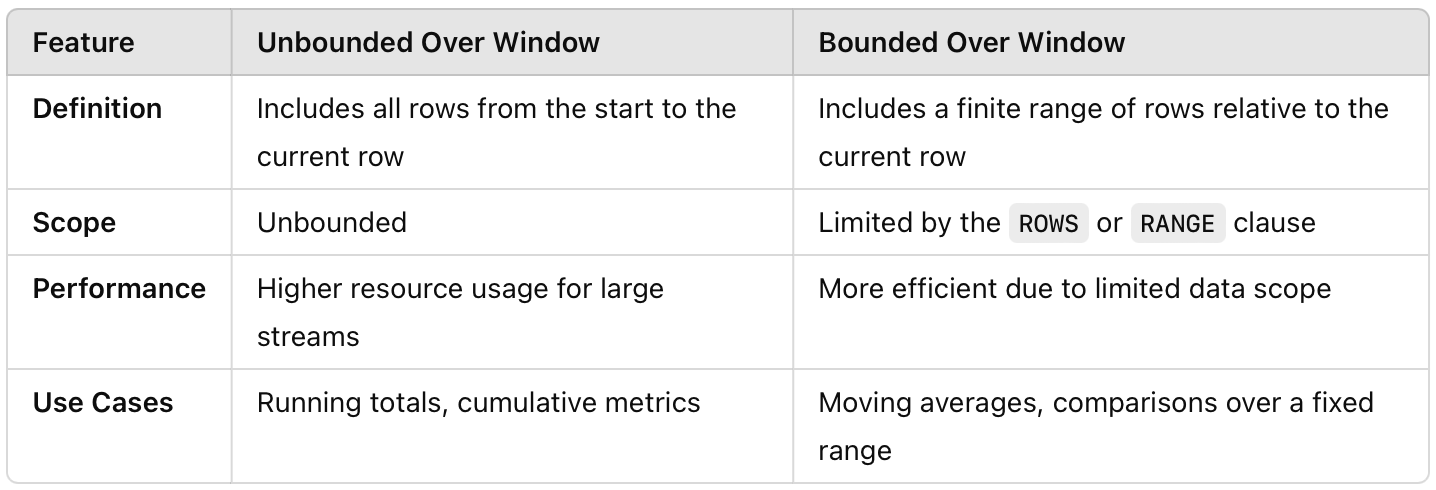

In [153]:
orders_table.execute().print()

+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                           ORD1 |                      Product_1 |                  100 |           1 | 2024-12-14 09:33:05.000000 |
|                           ORD2 |                      Product_1 |                  110 |           2 | 2024-12-14 09:38:05.000000 |
|                           ORD3 |                      Product_2 |                  120 |           3 | 2024-12-14 09:43:05.000000 |
|                           ORD4 |                      Product_2 |                  130 |           4 | 2024-12-14 09:48:05.000000 |
|                           ORD5 |                      Produc

In [164]:
env_settings = EnvironmentSettings.in_streaming_mode()
table_env = TableEnvironment.create(env_settings)

# Create table with watermark on `ordered_time`
table_env.execute_sql("""
    CREATE TABLE orders_table_fnl (
        order_id STRING,
        product STRING,
        price BIGINT,
        quantity INT,
        ordered_time TIMESTAMP(3),
        WATERMARK FOR ordered_time AS ordered_time - INTERVAL '1' SECOND
    ) WITH (
        'connector' = 'filesystem',
        'path' = '/Users/praveenreddy/FFlink/Flink_Work/orders.csv',
        'format' = 'csv'
    )
""")

In [ ]:
#UNBOUNDED_RANGE
#UNBOUNDED_ROW

orders_table_fnl = table_env.from_path("orders_table_fnl")
result = orders_table_fnl.over_window(
    Over.partition_by(col("product"))
        .order_by(col("ordered_time")) 
        .preceding(UNBOUNDED_RANGE)
        .alias("w")
).select(
    col("product"),
    col("order_id"),
    col("price").sum.over(col("w")).alias("running_total")
)


result.execute().print()

+----+--------------------------------+--------------------------------+----------------------+
| op |                        product |                       order_id |        running_total |
+----+--------------------------------+--------------------------------+----------------------+
| +I |                      Product_2 |                           ORD3 |                  120 |
| +I |                      Product_2 |                           ORD4 |                  250 |
| +I |                      Product_2 |                           ORD5 |                  390 |
| +I |                     Product_13 |                          ORD13 |                  220 |
| +I |                     Product_13 |                          ORD14 |                  450 |
| +I |                     Product_13 |                          ORD15 |                  690 |
| +I |                     Product_11 |                          ORD10 |                  190 |
| +I |                     Product_11 | 

In [161]:

orders_table_fnl = table_env.from_path("orders_table_fnl")
result = orders_table_fnl.over_window(
    Over.partition_by(col("product"))
        .order_by(col("ordered_time")) 
        .preceding(lit(10).minutes)
        .alias("w")
).select(
    col("product"),
    col("order_id"),
    col("price").sum.over(col("w")).alias("running_total")
)


result.execute().print()

+----+--------------------------------+--------------------------------+----------------------+
| op |                        product |                       order_id |        running_total |
+----+--------------------------------+--------------------------------+----------------------+
| +I |                     Product_13 |                          ORD13 |                  220 |
| +I |                     Product_13 |                          ORD14 |                  450 |
| +I |                     Product_13 |                          ORD15 |                  690 |
| +I |                      Product_1 |                           ORD1 |                  100 |
| +I |                      Product_1 |                           ORD2 |                  210 |
| +I |                      Product_1 |                           ORD6 |                  150 |
| +I |                     Product_14 |                          ORD16 |                  250 |
| +I |                     Product_14 | 

row_interval(2) in Apache Flink's OVER window, it includes the current row and two previous rows.

In [165]:
orders_table_fnl = table_env.from_path("orders_table_fnl")
result = orders_table_fnl.over_window(
    Over.partition_by(col("product"))
        .order_by(col("ordered_time")) 
        .preceding(row_interval(2))
        .alias("w")
).select(
    col("product"),
    col("order_id"),
    col("price").sum.over(col("w")).alias("running_total")
)


result.execute().print()

+----+--------------------------------+--------------------------------+----------------------+
| op |                        product |                       order_id |        running_total |
+----+--------------------------------+--------------------------------+----------------------+
| +I |                      Product_2 |                           ORD3 |                  120 |
| +I |                      Product_2 |                           ORD4 |                  250 |
| +I |                      Product_2 |                           ORD5 |                  390 |
| +I |                      Product_1 |                           ORD1 |                  100 |
| +I |                      Product_1 |                           ORD2 |                  210 |
| +I |                      Product_1 |                           ORD6 |                  360 |
| +I |                      Product_1 |                           ORD7 |                  420 |
| +I |                      Product_1 | 

In [166]:
orders_table.execute().print()

+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+-------------+----------------------------+
|                           ORD1 |                      Product_1 |                  100 |           1 | 2024-12-14 09:33:05.000000 |
|                           ORD2 |                      Product_1 |                  110 |           2 | 2024-12-14 09:38:05.000000 |
|                           ORD3 |                      Product_2 |                  120 |           3 | 2024-12-14 09:43:05.000000 |
|                           ORD4 |                      Product_2 |                  130 |           4 | 2024-12-14 09:48:05.000000 |
|                           ORD5 |                      Produc

without map, applying the UDF to a column

In [171]:
from pyflink.table.udf import udf

@udf(result_type="BIGINT")
def double_price(price: int):
    return price * 2

result_table = orders_table.select(
    col("order_id"),
    col("product"),
    col("price"),
    double_price(col("price")).alias("double_price"),
    col("quantity"),
    col("ordered_time")
)
result_table.execute().print()

+--------------------------------+--------------------------------+----------------------+----------------------+-------------+----------------------------+
|                       order_id |                        product |                price |         double_price |    quantity |               ordered_time |
+--------------------------------+--------------------------------+----------------------+----------------------+-------------+----------------------------+
|                           ORD1 |                      Product_1 |                  100 |                  200 |           1 | 2024-12-14 09:33:05.000000 |
|                           ORD2 |                      Product_1 |                  110 |                  220 |           2 | 2024-12-14 09:38:05.000000 |
|                           ORD3 |                      Product_2 |                  120 |                  240 |           3 | 2024-12-14 09:43:05.000000 |
|                           ORD4 |                      Pr

In [172]:
from pyflink.common import Row

map

In [174]:
def discount_function(a: Row) -> Row:
    return Row(a.price*0.1, a.price-a.price*0.1)

func = udf(discount_function, result_type=DataTypes.ROW(
                                     [DataTypes.FIELD("discount_value", DataTypes.FLOAT()),
                                      DataTypes.FIELD("to_pay_after_discount", DataTypes.FLOAT())]))

res = orders_table.map(func).alias('discount_value','to_pay_after_discount')
res.execute().print()

+--------------------------------+--------------------------------+
|                 discount_value |          to_pay_after_discount |
+--------------------------------+--------------------------------+
|                           10.0 |                           90.0 |
|                           11.0 |                           99.0 |
|                           12.0 |                          108.0 |
|                           13.0 |                          117.0 |
|                           14.0 |                          126.0 |
|                           15.0 |                          135.0 |
|                           16.0 |                          144.0 |
|                           17.0 |                          153.0 |
|                           18.0 |                          162.0 |
|                           19.0 |                          171.0 |
|                           20.0 |                          180.0 |
|                           21.0 |              

In [176]:
l = [(1001,"USB-TypeC-Hyd"),(1002,"Phone-16Iphone-Chn"),(1003,"Mac-MacAir-Mum")]

data = table_env.from_elements(l,['order_id','detail'])
data.execute().print()

+----+----------------------+--------------------------------+
| op |             order_id |                         detail |
+----+----------------------+--------------------------------+
| +I |                 1001 |                  USB-TypeC-Hyd |
| +I |                 1002 |             Phone-16Iphone-Chn |
| +I |                 1003 |                 Mac-MacAir-Mum |
+----+----------------------+--------------------------------+
3 rows in set


In [177]:
@udtf(result_types=[DataTypes.STRING(), DataTypes.STRING()])
def mthd(x: Row) -> Row:
    return Row(x.detail.split('-')[0],x.detail.split('-')[1])


res = data.flat_map(mthd)
res.execute().print()

+----+--------------------------------+--------------------------------+
| op |                             f0 |                             f1 |
+----+--------------------------------+--------------------------------+
| +I |                            USB |                          TypeC |
| +I |                          Phone |                       16Iphone |
| +I |                            Mac |                         MacAir |
+----+--------------------------------+--------------------------------+
3 rows in set


In [178]:
data.join_lateral(mthd.alias('a', 'b')).execute().print()

+----+----------------------+--------------------------------+--------------------------------+--------------------------------+
| op |             order_id |                         detail |                              a |                              b |
+----+----------------------+--------------------------------+--------------------------------+--------------------------------+
| +I |                 1001 |                  USB-TypeC-Hyd |                            USB |                          TypeC |
| +I |                 1002 |             Phone-16Iphone-Chn |                          Phone |                       16Iphone |
| +I |                 1003 |                 Mac-MacAir-Mum |                            Mac |                         MacAir |
+----+----------------------+--------------------------------+--------------------------------+--------------------------------+
3 rows in set


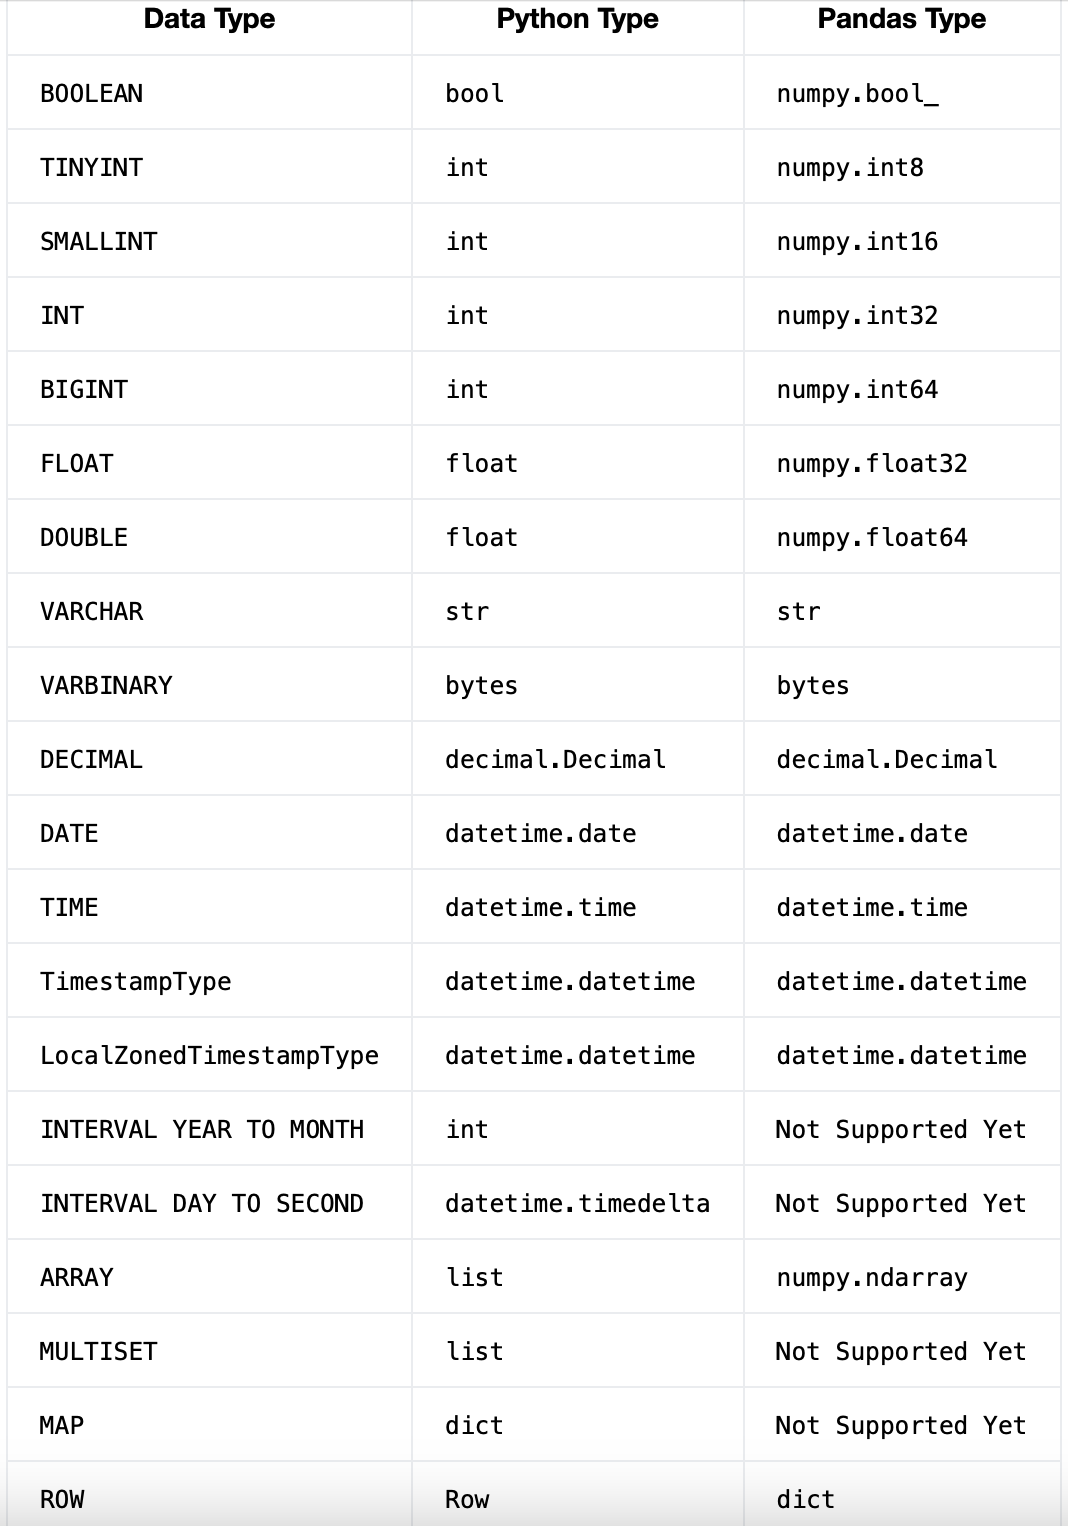